In [ ]:
 import numpy as np
from scipy.spatial import cKDTree

def load_xyz(filename):
    return np.loadtxt(filename, delimiter=' ')

from scipy.spatial import cKDTree
import numpy as np


def chamfer_distance(point_cloud1, point_cloud2):
    tree1 = cKDTree(point_cloud1)
    tree2 = cKDTree(point_cloud2)
    distances_1, _ = tree1.query(point_cloud2, p=2)
    distances_2, _ = tree2.query(point_cloud1, p=2)
    chamfer_dist = np.mean(distances_1**2) + np.mean(distances_2**2)

    return chamfer_dist

def cartesian_to_spherical(points):
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return np.vstack((r, theta, phi)).T

def spherical_chamfer_distance(point_cloud1, point_cloud2):
    sph_cloud1 = cartesian_to_spherical(point_cloud1)
    sph_cloud2 = cartesian_to_spherical(point_cloud2)

    tree1 = cKDTree(sph_cloud1)
    tree2 = cKDTree(sph_cloud2)

    distances_1, _ = tree1.query(sph_cloud2)
    distances_2, _ = tree2.query(sph_cloud1)

    spherical_chamfer_dist = np.mean(distances_1**2) + np.mean(distances_2**2)

    return spherical_chamfer_dist

def point_to_face_distance(point_cloud1, point_cloud2):
    tree = cKDTree(point_cloud2)

    distances, _ = tree.query(point_cloud1)

    p2f_distance = np.mean(distances**2)

    return p2f_distance


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_xyz(file_path):
    # Read .xyz file
    with open(file_path, 'r') as file:
        lines = file.readlines()[:]

    x, y, z = [], [], []
    for line in lines:
        parts = line.split()
        if len(parts) >= 3:
            x.append(float(parts[0]))
            y.append(float(parts[1]))
            z.append(float(parts[2]))

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# print("Ground Truth")
# file_path = "/content/data/clean/Pyramid.xyz"
# plot_xyz(file_path)

In [ ]:
# print("Noisy")
# file_path = "/content/data/noisy/Pyramid.xyz"
# plot_xyz(file_path)

In [ ]:
# file_path = "/content/output/denoised_output1.xyz"
# plot_xyz(file_path)

In [ ]:
import shutil
import os

source_file = '/content/data/clean/Pyramid.xyz'

destination_directory = '/content/data/clean'

os.makedirs(destination_directory, exist_ok=True)

for i in range(1, 81):
    destination_file = os.path.join(destination_directory, f"{i}{os.path.splitext(source_file)[1]}")
    shutil.copy(source_file, destination_file)

print("80 copies created successfully!")


80 copies created successfully!


In [ ]:
import numpy as np
import os
from pathlib import Path

def add_gaussian_noise(points, mean=0, std=0.02):
    noise = np.random.normal(mean, std, points.shape)
    return points + noise

def process_xyz_files(input_dir, output_dir, std=0.02):
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith('.xyz'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            points = np.loadtxt(input_path)

            noisy_points = add_gaussian_noise(points, std=std)

            np.savetxt(output_path, noisy_points, fmt='%.6f')

input_dir = '/content/data/clean'
output_dir = '/content/data/noisy'
noise_std = 0.02 # Noise

process_xyz_files(input_dir, output_dir, std=noise_std)

In [ ]:
from torch.nn import functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path

# Custom Dataset
class PointCloudDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir):
        self.clean_files = sorted([os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.xyz')])
        self.noisy_files = sorted([os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir) if f.endswith('.xyz')])

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_points = torch.tensor(np.loadtxt(self.clean_files[idx]), dtype=torch.float32)
        noisy_points = torch.tensor(np.loadtxt(self.noisy_files[idx]), dtype=torch.float32)
        return clean_points, noisy_points

# # Generator Network
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(3, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 3)
#         )

#     def forward(self, x):
#         # x shape: [batch_size, num_points, 3]
#         batch_size, num_points, _ = x.shape
#         x_reshaped = x.view(-1, 3)  # Reshape to [batch_size * num_points, 3]

#         features = self.encoder(x_reshaped)
#         denoised = self.decoder(features)

#         return denoised.view(batch_size, num_points, 3)

# # Discriminator Network
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.point_features = nn.Sequential(
#             nn.Linear(3, 64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 64),
#             nn.LeakyReLU(0.2)
#         )

#         self.global_features = nn.Sequential(
#             nn.Linear(64, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#
#         batch_size, num_points, _ = x.shape
#         x_reshaped = x.view(-1, 3)  # Reshape to [batch_size * num_points, 3]

#
#         point_features = self.point_features(x_reshaped)
#         point_features = point_features.view(batch_size, num_points, -1)

#
#         global_features = torch.max(point_features, dim=1)[0]

#
#         validity = self.global_features(global_features)  # Shape: [batch_size, 1]
#         return validity

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Linear(in_channels, out_channels)
        self.conv2 = nn.Linear(out_channels, out_channels)
        self.shortcut = nn.Linear(in_channels, out_channels) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        return F.relu(out + self.shortcut(x))

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            ResidualBlock(128, 256),
            ResidualBlock(256, 512),
            nn.ReLU(),
        )

        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8)

        self.decoder = nn.Sequential(
            ResidualBlock(512, 256),
            ResidualBlock(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        batch_size, num_points, _ = x.shape
        x_reshaped = x.view(-1, 3)
        features = self.encoder(x_reshaped)

        features = features.unsqueeze(0)
        attn_output, _ = self.attention(features, features, features)

        denoised = self.decoder(attn_output.squeeze(0))

        return denoised.view(batch_size, num_points, 3)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.point_features = nn.Sequential(
            nn.Linear(3, 128),
            nn.LeakyReLU(0.2),
            ResidualBlock(128, 256),
            ResidualBlock(256, 512),
            nn.LeakyReLU(0.2),
        )

        self.global_features = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_points, _ = x.shape
        x_reshaped = x.view(-1, 3)

        point_features = self.point_features(x_reshaped)
        point_features = point_features.view(batch_size, num_points, -1)

        global_features = torch.mean(point_features, dim=1)
        validity = self.global_features(global_features)
        return validity

# Training
def train_gan(clean_dir, noisy_dir, num_epochs=100, batch_size=32, lr=0.0002, beta1=0.5):
    dataset = PointCloudDataset(clean_dir, noisy_dir)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    adversarial_loss = nn.BCELoss()
    l1_loss = nn.L1Loss()

    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    for epoch in range(num_epochs):
        for i, (clean_points, noisy_points) in enumerate(dataloader):
            clean_points = clean_points.to(device)
            noisy_points = noisy_points.to(device)
            batch_size = clean_points.size(0)

            if len(clean_points.shape) == 2:
                clean_points = clean_points.unsqueeze(0)
                noisy_points = noisy_points.unsqueeze(0)

            valid = torch.ones((batch_size, 1), device=device)
            fake = torch.zeros((batch_size, 1), device=device)


            generated_points = generator(noisy_points)



            g_optimizer.zero_grad()


            g_loss_adv = adversarial_loss(discriminator(generated_points), valid)
            g_loss_l1 = l1_loss(generated_points, clean_points)

            g_loss = g_loss_adv + 100 * g_loss_l1  # Lambda weight for L1 loss
            g_loss.backward()
            g_optimizer.step()

             # Train Discriminator
            d_optimizer.zero_grad()

            d_loss_real = adversarial_loss(discriminator(clean_points), valid)
            d_loss_fake = adversarial_loss(discriminator(generated_points.detach()), fake)

            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            d_optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    return generator

# Testing
def test_model(generator, input_file, output_file):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.eval()

    input_points = torch.tensor(np.loadtxt(input_file), dtype=torch.float32).to(device)

    if len(input_points.shape) == 2:
        input_points = input_points.unsqueeze(0)

    with torch.no_grad():
        denoised_points = generator(input_points)
        denoised_points = denoised_points.squeeze(0)

    np.savetxt(output_file, denoised_points.cpu().numpy(), fmt='%.6f')

def main():
    clean_dir = '/content/data/clean'
    noisy_dir = '/content/data/noisy'
    output_dir = '/content/output'
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    print("Starting training...")
    generator = train_gan(clean_dir, noisy_dir)

    torch.save(generator.state_dict(), os.path.join(output_dir, 'generator.pth'))

    # Test the model on all files in the noisy directory
    # print("\nStarting testing...")
    # for filename in os.listdir(noisy_dir):
    #     if filename.endswith('.xyz'):
    #         input_file = os.path.join(noisy_dir, filename)
    #         output_file = os.path.join(output_dir, f'denoised_{filename}')
    #         test_model(generator, input_file, output_file)
    #         print(f"Processed {filename}")

if __name__ == "__main__":
    main()

Starting training...
Epoch [10/100] D_loss: 0.6911 G_loss: 6.0586
Epoch [20/100] D_loss: 0.6934 G_loss: 6.5749
Epoch [30/100] D_loss: 0.6731 G_loss: 3.5592
Epoch [40/100] D_loss: 0.6831 G_loss: 3.0136
Epoch [50/100] D_loss: 0.6954 G_loss: 3.0642
Epoch [60/100] D_loss: 0.6953 G_loss: 2.6811
Epoch [70/100] D_loss: 0.6866 G_loss: 3.0149
Epoch [80/100] D_loss: 0.6943 G_loss: 2.7883
Epoch [90/100] D_loss: 0.6942 G_loss: 2.7308
Epoch [100/100] D_loss: 0.6928 G_loss: 2.6843


In [ ]:
input_dir = '/content/data/clean'
output_dir = '/content/data/noisy'
noise_std = 0.02 # Noise

process_xyz_files(input_dir, output_dir, std=noise_std)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load('/content/output/generator.pth'))
generator.eval()

input_file = "/content/data/noisy/Pyramid.xyz"
output_file = "/content/output/denoised_output1.xyz"
test_model(generator, input_file, output_file)

<ipython-input-11-c263889fe4b4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/output/generator.pth'))


In [ ]:
point_cloud1 = load_xyz("/content/data/clean/Pyramid.xyz")
point_cloud2 = load_xyz("/content/output/denoised_output1.xyz")
chamfer_dist = chamfer_distance(point_cloud1, point_cloud2)
print("Generated Output")
print("Chamfer Distance:", chamfer_dist)
print("Spherical Chamfer Distance:", spherical_chamfer_distance(point_cloud1, point_cloud2))
print("Point to Face Distance:", point_to_face_distance(point_cloud1, point_cloud2))

Generated Output
Chamfer Distance: 0.0006367751477842
Spherical Chamfer Distance: 0.0025172885375015644
Point to Face Distance: 0.00023964140335989997


In [ ]:
point_cloud1 = load_xyz("/content/data/clean/Pyramid.xyz")
point_cloud2 = load_xyz("/content/data/noisy/Pyramid.xyz")
chamfer_dist = chamfer_distance(point_cloud1, point_cloud2)
print("Noisy")
print("Chamfer Distance:", chamfer_dist)
print("Spherical Chamfer Distance:", spherical_chamfer_distance(point_cloud1, point_cloud2))
print("Point to Face Distance:", point_to_face_distance(point_cloud1, point_cloud2))

Noisy
Chamfer Distance: 0.0006358734534453
Spherical Chamfer Distance: 0.0025532046326690472
Point to Face Distance: 0.0001962535586082


Noisy


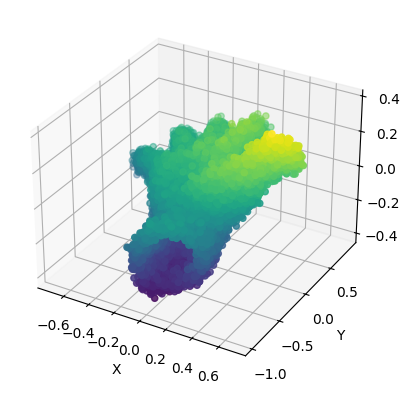

In [ ]:
print("Noisy")
file_path = "/content/data/noisy/Pyramid.xyz"
plot_xyz(file_path)

In [ ]:
import os

def iterative_denoising(generator, input_file, output_dir, k = 2):
    os.makedirs(output_dir, exist_ok=True)
    current_input = input_file
    for i in range(1, k + 1):
        current_output = os.path.join(output_dir, f"denoised_output_iter_{i}.xyz")
        test_model(generator, current_input, current_output)

        print(f"Iteration {i}: Denoised file saved at {current_output}")
        current_input = current_output

    print(f"Final denoised file after {k} iterations: {current_input}")
    return current_input

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load('/content/output/generator.pth'))
generator.eval()

input_file = "/content/output/denoised_output1.xyz"
output_dir = "/content/denoised_outputs"


final_output = iterative_denoising(generator, input_file, output_dir)
print(f"The final output file is located at: {final_output}")


Iteration 1: Denoised file saved at /content/denoised_outputs/denoised_output_iter_1.xyz
Iteration 2: Denoised file saved at /content/denoised_outputs/denoised_output_iter_2.xyz
Final denoised file after 2 iterations: /content/denoised_outputs/denoised_output_iter_2.xyz
The final output file is located at: /content/denoised_outputs/denoised_output_iter_2.xyz


<ipython-input-15-dd4842e191a0>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/output/generator.pth'))


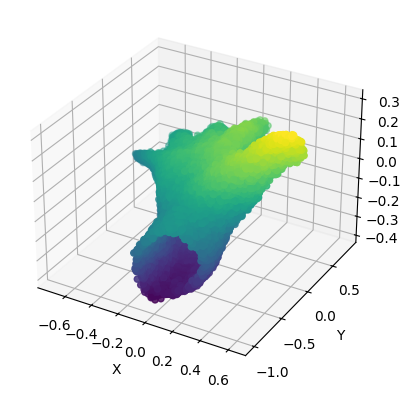

In [ ]:
plot_xyz('/content/denoised_outputs/denoised_output_iter_1.xyz')

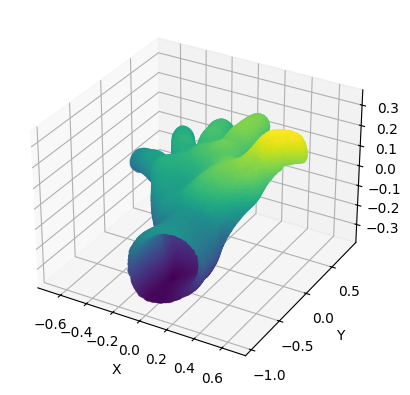

In [ ]:
file_path = "/content/data/clean/Pyramid.xyz"
plot_xyz(file_path)